In [1]:
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

from python import classes, metrics, data_loader

In [2]:
notebook_name = "main"
notebook_classification = "models"
notebook_cv = 3

image_size = 128
batch_size = 64
max_epochs = 200
early_stopping_patience = 5
total_cv = 5

data_dir = "data"
tensorboard_dir = "out/logs"
metrics_dir = "out/metrics"
models_dir = "out/keras"
weights_dir = "out/weights"

In [4]:
assert notebook_name != "", "notebook_name must be provided"
assert notebook_classification in ['models', 'types'], "notebook_classification must be one of ['models', 'types']"
assert notebook_cv != 0, "notebook_cv must be provided"
assert notebook_cv <= total_cv, "notebook_cv must not be greater than total_cv"

In [5]:
class_names = classes.class_names[notebook_classification]
classes_num = len(class_names)
metrics.classes_num = classes_num

notebook_model = "simple"
data_dir = Path(data_dir) / f"{notebook_classification}"
tensorboard_dir = Path(tensorboard_dir) / f"{notebook_model}/{notebook_classification}/{notebook_name}/cv{notebook_cv}"
metrics_file = Path(metrics_dir) / f"{notebook_model}/{notebook_classification}/{notebook_name}.json"
model_file = Path(models_dir) / f"{notebook_model}/{notebook_classification}/{notebook_name}/cv{notebook_cv}.keras"
weights_file = Path(weights_dir) / f"{notebook_model}/{notebook_classification}/{notebook_name}/cv{notebook_cv}.weights.h5"

In [6]:
assert not model_file.is_file(), "This model already exists"

In [7]:
shutil.rmtree(tensorboard_dir, ignore_errors=True)

tensorboard_dir.mkdir(parents=True, exist_ok=True)
metrics_file.parent.mkdir(parents=True, exist_ok=True)
model_file.parent.mkdir(parents=True, exist_ok=True)
weights_file.parent.mkdir(parents=True, exist_ok=True)

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
train_data, val_data = data_loader.load_data(
    data_dir=data_dir,
    val_fold=notebook_cv,
    total_folds=total_cv,
    class_names=class_names,
    batch_size=batch_size,
    image_size=image_size,
    buffer_size=10000
)

Found 6383 files belonging to 74 classes.
Found 6384 files belonging to 74 classes.
Found 6384 files belonging to 74 classes.
Found 6383 files belonging to 74 classes.
Found 6383 files belonging to 74 classes.


In [10]:
model = models.Sequential()
model.add(layers.Input(shape=(image_size, image_size, 3)))
model.add(layers.Rescaling(1./255)),

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(classes_num, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 74)             │         4,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,570 (1.43 MB)

 Trainable params: 374,570 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=["accuracy", metrics.f1_m, metrics.precision_m, metrics.recall_m]
)

In [12]:
checkpoint = ModelCheckpoint(weights_file, save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)
tensorboard = TensorBoard(log_dir=tensorboard_dir)

model.fit(
    train_data, epochs=max_epochs, validation_data=val_data, 
    callbacks=[
        checkpoint, early_stop, tensorboard
    ]
);

400/400 ━━━━━━━━━━━━━━━━━━━━ 72s 156ms/step - accuracy: 0.0483 - f1_m: 0.0000e+00 - loss: 4.1217 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.0508 - val_f1_m: 0.0000e+00 - val_loss: 4.0211 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00


In [13]:
y_true, y_pred = metrics.model_predict(model, val_data)

In [14]:
fold_metrics = metrics.evaluate_metrics(y_true, y_pred)
metrics.save_metrics(fold_metrics, metrics_file, notebook_cv)
fold_metrics

{'f1': 0.050759781152009964,
 'precision': 0.050759829580783844,
 'recall': 0.050759829580783844}

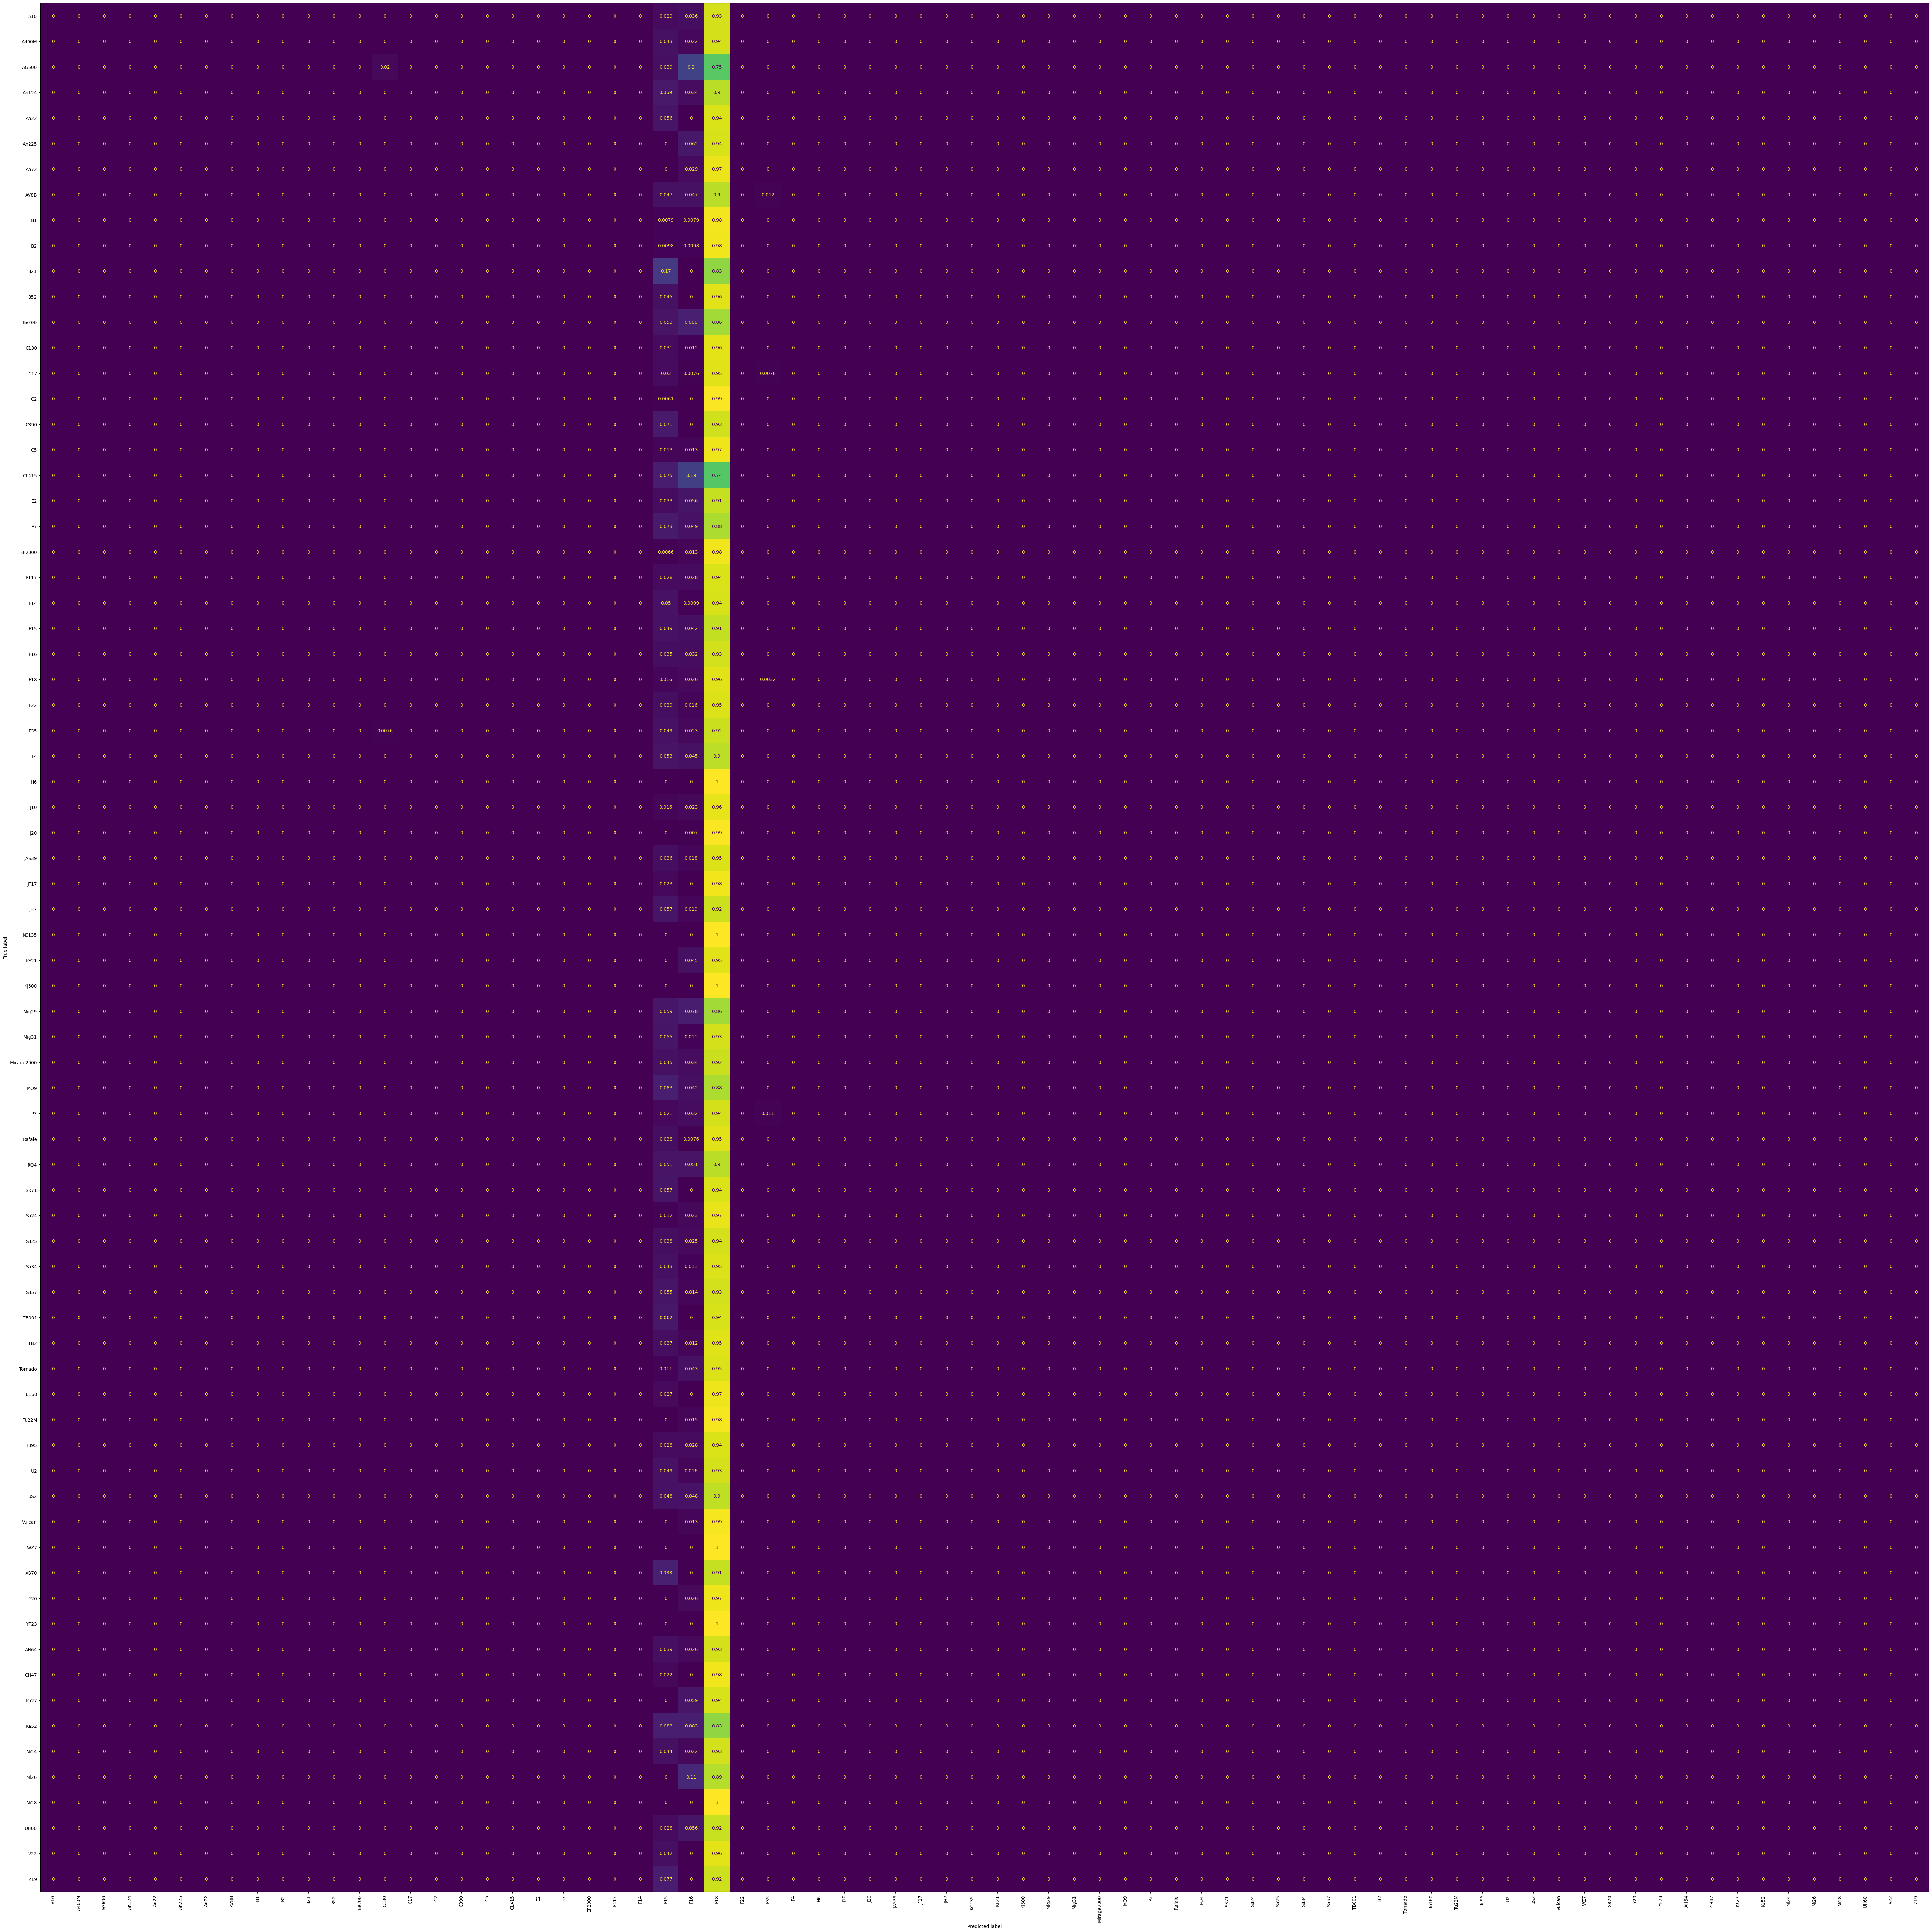

In [15]:
fig, ax = plt.subplots(figsize=(max(classes_num, 6), max(classes_num, 6)))
cmp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true", display_labels=class_names, colorbar=False, xticks_rotation='vertical', ax=ax)

In [16]:
model.save(model_file)